## Import Packages

In [2]:
!pip install transformers
import numpy as np
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig,TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import tensorflow_hub as hub

import numpy as np

import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

## Load data  & Exp & Processing

In [ ]:
# Download Dataset
#!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/IMDB"

Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/IMDB/test.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/IMDB/train.csv  


In [ ]:
# View a sample of data and encode categories
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB/train.csv')
df_test= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB/test.csv')

# Combine training and test data
df=pd.concat([df_train,df_test],keys=('train','test'))
#Count the length of reviews
review_length = [len(text.split()) for text in df['text']]
df["review_len"] = review_length
df.head()

text sentiment  \
train 0  Now, I won't deny that when I purchased this o...       neg   
      1  The saddest thing about this "tribute" is that...       neg   
      2  Last night I decided to watch the prequel or s...       neg   
      3  I have to admit that i liked the first half of...       neg   
      4  I was not impressed about this film especially...       neg   

         review_len  
train 0         137  
      1         313  
      2         180  
      3         162  
      4         195

In [ ]:
df['sentiment'].value_counts()

neg    25000
pos    25000
Name: sentiment, dtype: int64

In [ ]:
df["review_len"].max()

2470

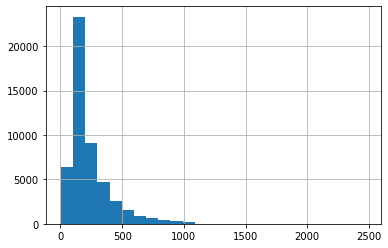

In [ ]:
df["review_len"].hist(bins=25)

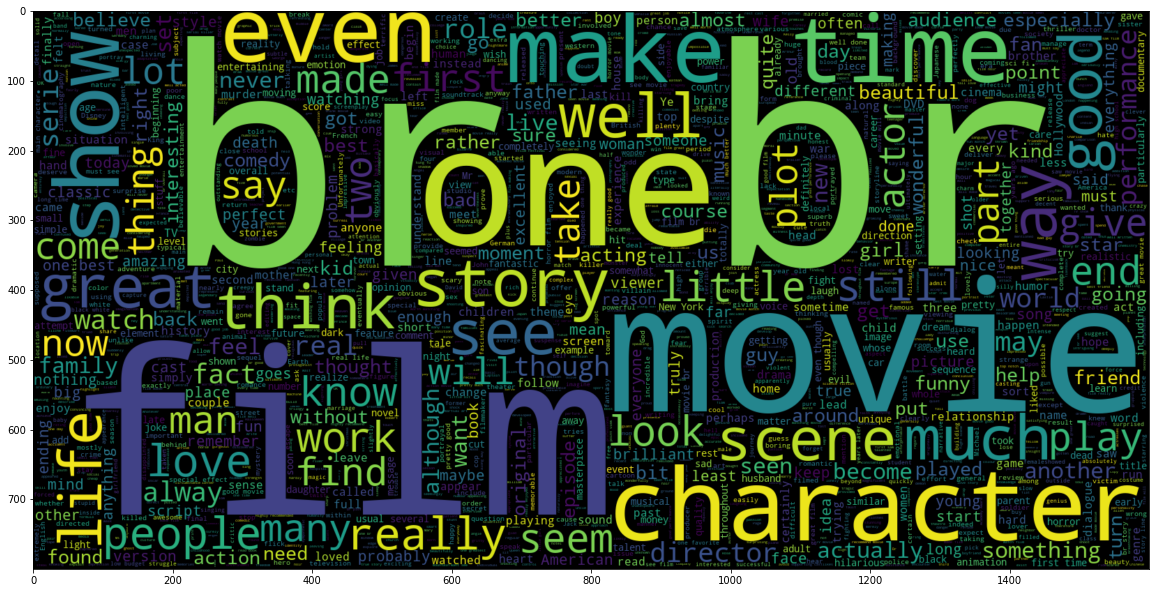

In [ ]:
# positive WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'pos'].text))                                                                       
plt.imshow(wc, interpolation='bilinear')

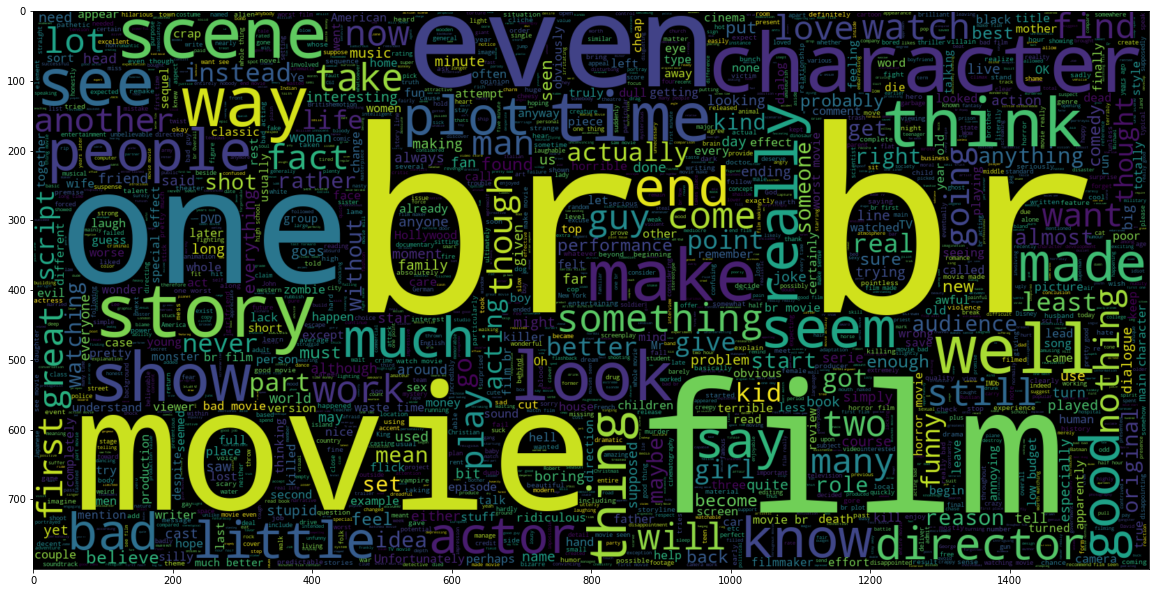

In [ ]:
# negative WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'neg'].text))                                                                       
plt.imshow(wc, interpolation='bilinear')

In [ ]:
# replace contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}
def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text
df['text']=df['text'].apply(remove_contractions)
df.head()

text sentiment  \
train 0  Now, I won't deny that when I purchased this o...       neg   
      1  The saddest thing about this "tribute" is that...       neg   
      2  Last night I decided to watch the prequel or s...       neg   
      3  I have to admit that i liked the first half of...       neg   
      4  I was not impressed about this film especially...       neg   

         review_len  
train 0         137  
      1         313  
      2         180  
      3         162  
      4         195

In [ ]:
# clean
def clean(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove words with 2 or fewer letters
    text = ' '.join(re.sub(r'\b\w{1,2}\b', '', x) if x !='ok' else x for x in text.split())
    # remove stopwords
    from nltk.corpus import stopwords
    stopwords=stopwords.words('english')
    stopwords.extend(['wont'])  
    text=' '.join([x for x in filter(lambda x: x not in stopwords,text.split())])
    # Remove numbers
    text=re.sub(r'\w*\d+\w*', '', text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())  
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    return text

df['text'] =df['text'].str.lower().apply(clean)

In [ ]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/IMDB/df_clean.csv')
#df.head()

text sentiment  \
train 0  deny purchased ebay high expectations incredib...       neg   
      1  saddest thing tribute almost singers including...       neg   
      2  last night decided watch prequel shall say cal...       neg   
      3  admit liked first half sleepers looked good ac...       neg   
      4  impressed film especially fact went cinema fam...       neg   

         review_len  
train 0         137  
      1         313  
      2         180  
      3         162  
      4         195

In [ ]:
# Code for applying lemmatization to text
# It might need a little development
POS_adapter={
    'VVB':'v',
    'VBD':'v',
    'VBG':'v',
    'VBN':'v',
    'VBP':'v',
    'VBZ':'v',
    'NN':'n',
    'NNS':'n',
    'NNP':'n',
    'NNPS':'n',
    'JJ':'a',
    'JJR':'a',
    'JJS':'s',
    'RB':'r',
    'RBR':'r',
    'RBS':'r'
}

def wordToLemma(token):
  import nltk 
  from nltk.stem import WordNetLemmatizer
  lemmatizer = WordNetLemmatizer()
  pos_tag=nltk.pos_tag(token.split())[0][1]
  return lemmatizer.lemmatize(token, pos =POS_adapter[pos_tag]) if pos_tag in POS_adapter.keys() else token

def textNormlaization(text):
  return " ".join([wordToLemma(token) for token in text.split()])

df['text']=df["text"].apply(textNormlaization)

In [ ]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/IMDB/df_clean2.csv')

In [ ]:
df["review_len"]=[len(text.split()) for text in df['text']]
df["review_len"].max()

1397

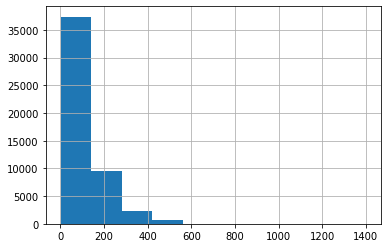

In [ ]:
df["review_len"].hist()

## Setting up a pre-trained BERT model for fine-tuning

In [14]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB/df_clean2.csv')
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df['sentiment']=df['sentiment'].map({'neg':0,'pos':1})
df.head()

,text,sentiment,review_len
0,deny purchase ebay high expectation incredible...,0,59
1,saddest thing tribute almost singer include ot...,0,157
2,last night decide watch prequel shall say call...,0,89
3,admit like first half sleeper look good act ev...,0,77
4,impressed film especially fact go cinema famil...,0,79


In [15]:
train_df=df.loc[:24999]
test_df=df.loc[25000:]

In [16]:
num_classes=len(df.sentiment.unique())
print('Available labels: ',num_classes)

Available labels:  2


In [17]:
# BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

NameError: ignored

In [18]:
def bertInput(sentences,labels):
    input_ids=[]
    attention_masks=[]
    for sent in sentences:
        bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =512,truncation=True,padding = 'max_length',return_attention_mask = True)
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    return np.asarray(input_ids),np.array(attention_masks),np.array(labels)

In [ ]:
input_ids_train,attention_masks_train,labels_train=bertInput(train_df['text'],train_df['sentiment'])
input_ids_test,attention_masks_test,labels_test=bertInput(test_df['text'],test_df['sentiment'])

In [ ]:
print('Preparing the pickle file.....')
# train_data
pickle_inp_path_train='/content/drive/MyDrive/Colab Notebooks/IMDB/pickle_file/dbert_inp_train.pkl'
pickle_mask_path_train='/content/drive/MyDrive/Colab Notebooks/IMDB/pickle_file/dbert_mask_train.pkl'
pickle_label_path_train='/content/drive/MyDrive/Colab Notebooks/IMDB/pickle_file/dbert_label_train.pkl'

pickle.dump((input_ids_train),open(pickle_inp_path_train,'wb'))
pickle.dump((attention_masks_train),open(pickle_mask_path_train,'wb'))
pickle.dump((labels_train),open(pickle_label_path_train,'wb))

# test data
pickle_inp_path_test='/content/drive/MyDrive/Colab Notebooks/IMDB/pickle_file/dbert_inp_test.pkl'
pickle_mask_path_test='/content/drive/MyDrive/Colab Notebooks/IMDB/pickle_file/dbert_mask_test.pkl'
pickle_label_path_test='/content/drive/MyDrive/Colab Notebooks/IMDB/pickle_file/dbert_label_test.pkl'

pickle.dump((input_ids_test),open(pickle_inp_path_test,'wb'));
pickle.dump((attention_masks_test),open(pickle_mask_path_test,'wb'));
pickle.dump((labels_test),open(pickle_label_path_test,'wb'));

print('Pickle files saved')

Preparing the pickle file.....
Pickle files saved


In [5]:
print('Loading the saved pickle files..')

input_ids_train,attention_masks_train,labels_train=pickle.load(open(pickle_inp_path_train, 'rb')),pickle.load(open(pickle_mask_path_train, 'rb')),pickle.load(open(pickle_label_path_train, 'rb'))
input_ids_test,attention_masks_test,labels_test=pickle.load(open(pickle_inp_path_test, 'rb')),pickle.load(open(pickle_mask_path_test, 'rb')),pickle.load(open(pickle_label_path_test, 'rb'))

print('Pickle files loaded')

Loading the saved pickle files..
Pickle files loaded


In [6]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids_train,labels_train,attention_masks_train,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


Train inp shape (20000,) Val input shape (5000,)
Train label shape (20000,) Val label shape (5000,)
Train attention mask shape (20000,) Val attention mask shape (5000,)


In [10]:
log_dir='/content/drive/MyDrive/Colab Notebooks/IMDB/tensorboard_data/tb_bert'
model_save_path='/content/drive/MyDrive/Colab Notebooks/IMDB/models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True),tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [11]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=10,
                       validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/10


ResourceExhaustedError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
model_save_path='./bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))

print('Training and saving built model.....')   

In [ ]:
model.predict gives the probability of the labels, Let's say we have 10 val_inp then dimensions of the preds will be (10,2)Then we apply argmax and obtain the predicted labels.pred_labels.shape -- (10,)eg. preds:array([[0.34,0.72],
       [0.2,0.8]]) and so on. 
this means that for 1st sample the prob. of the label 0 is 0.34 and prob. of 1 label is 0.72so we take the argmax in axis=1 and get the label of the maximum probabilitypred_labels:
[1,1....]

In [ ]:
trained_model.evaluate([val_inp,val_mask],batch_size=32)